# Visualizing Convolutional Neural Nets
This notebook is focused around the visualization of convnet learning representations. The following will be visualized:
- Convnet outputs from intermediate activations
- Convnet filters
- heatmaps of class activation

## Visualizing Intermediate Activations
Intermediate activations will be visualized by outputting the 3D filters (feature maps) of a convolutional layer. Each filter consists of 3 channels for an RGB image, so each channel will be displayed as a 2D image.

In [0]:
%tensorflow_version 2.x
from tensorflow.keras import models
from keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### Mount google drive first ###
base_dir = os.getcwd() + '/drive/My Drive/Colab Notebooks/Deep Learning in Python/Deep Learning for Computer Vision'
# original_dataset_dir = base_dir + '/kaggle_cat_dog_orig_smaller' # location of original uncompressed dataset

# # Directories for train / validation /test data splits
# train_dir = os.path.join(base_dir, 'train')
# validation_dir = os.path.join(base_dir, 'validation')
# test_dir = os.path.join(base_dir, 'test')

# # train
# train_cats_dir = os.path.join(train_dir, 'cats')
# train_dogs_dir = os.path.join(train_dir, 'dogs')

# # validation
# validation_cats_dir = os.path.join(validation_dir, 'cats')
# validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# #test
# test_cats_dir = os.path.join(test_dir, 'cats')
# test_dogs_dir = os.path.join(test_dir, 'dogs')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Load prev trained model
model = models.load_model(base_dir + '/cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 128)      

In [0]:
# Preprocess a chosen test image
img_path = base_dir + '/test/cats/cat.1700.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) #4D tensor conversion
img_tensor = img_tensor/255 #Same preprocessing done during model training

print(img_tensor.shape)

(1, 150, 150, 3)


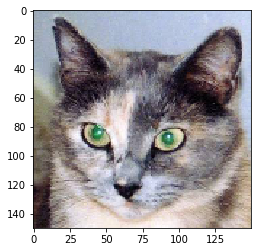

In [0]:
# Display selected image
plt.imshow(img_tensor[0])
plt.show()

To output the activations of all convolutional and pooling layers, we'll use Keras' *Model* class which allows for multiple outputs.

In [0]:
# Model takes one input tensor, outputs list of output tensors
layer_outputs = [layer.output for layer in model.layers[:8]] #First 8 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Example input
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


We can see that the first layer outputs a 148 x 148 feature map with 32 filters/output channels.

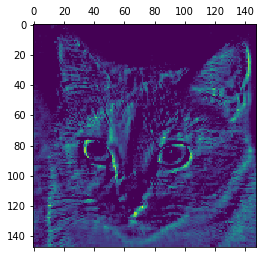

In [0]:
# Visualize 4th output channel of 1st layer
plt.matshow(first_layer_activation[0,:,:,4], cmap='viridis')

The channel above appears to detect white tints of the image.

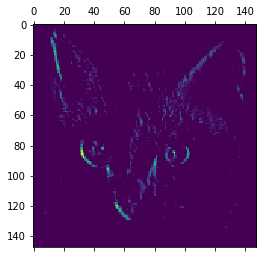

In [0]:
# Visualize 7th output channel of 1st layer
plt.matshow(first_layer_activation[0,:,:,7], cmap='viridis')

This channel seems to detect diagonal edges.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


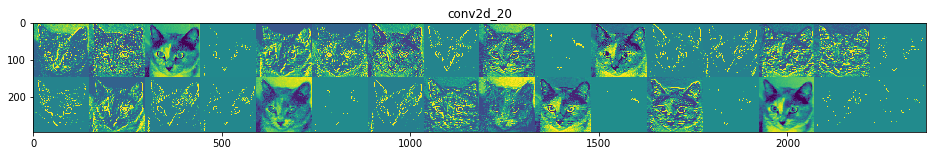

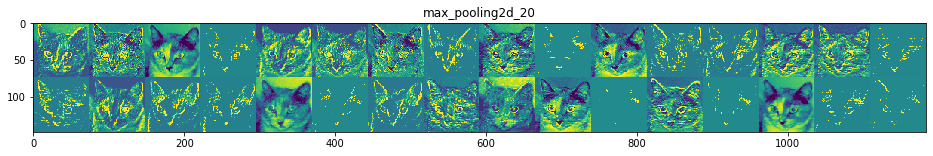

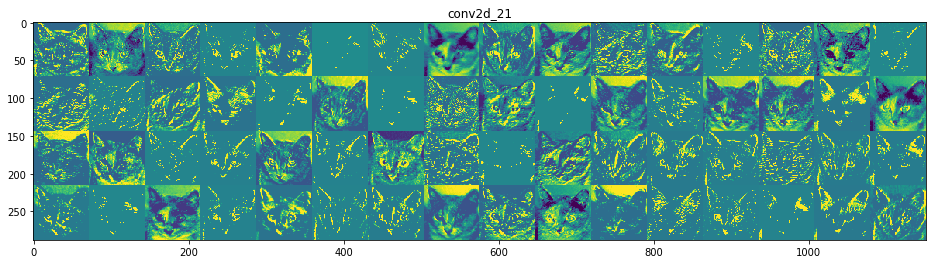

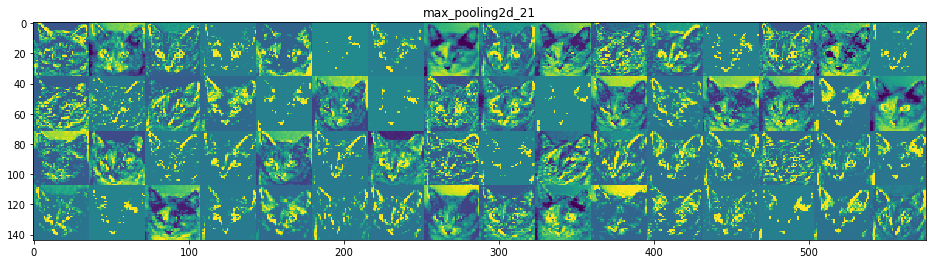

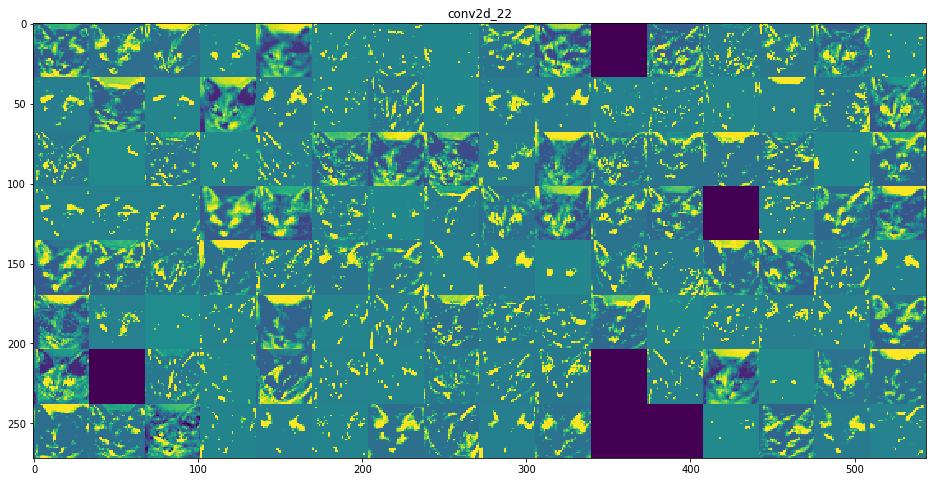

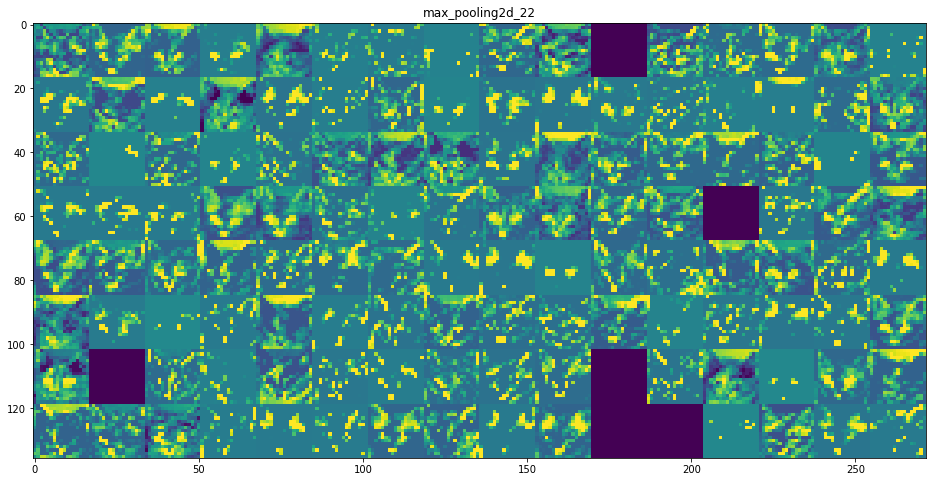

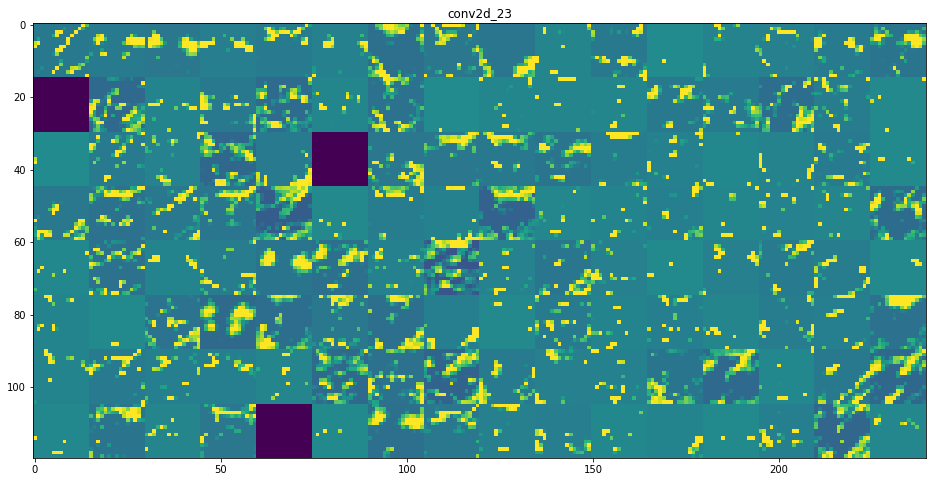

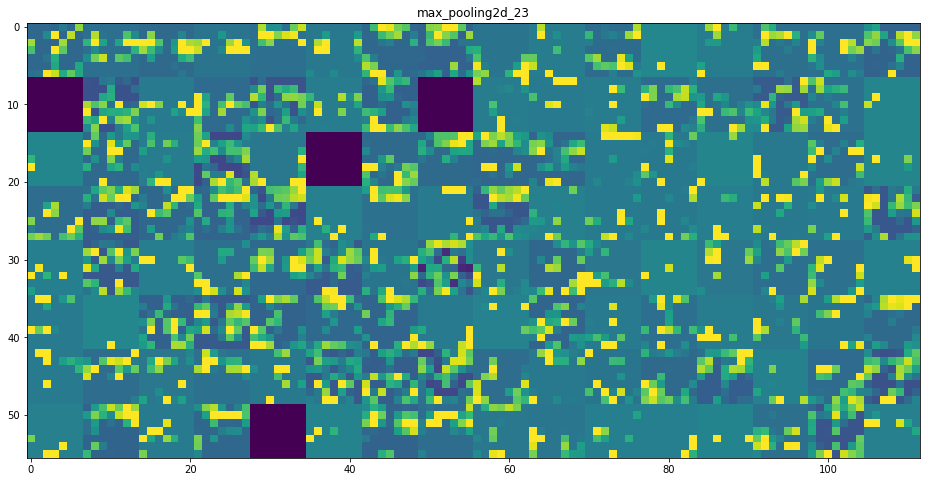

In [0]:
# Visualize each output channel of each layer activation
layer_names = [layer.name for layer in model.layers[:8]]
images_per_row=16

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]

  n_cols = n_features // images_per_row
  display_grid = np.zeros((size*n_cols, images_per_row*size))

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0,:,:,col*images_per_row + row]
      # Post-process img values
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image = 64*channel_image + 128
      # Limit rescaled image values to valid pixel vals
      channel_image = np.clip(channel_image, 0 , 255).astype('uint8')
      display_grid[col*size : (col+1)*size,
                   row*size : (row+1)*size] = channel_image
  
  scale = 1/size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Visualizing Convnet Filters
To visualize a filter in a CNN, we will use gradient descent to update the value of an input image to maximize the response of a filter (starting from a blank image). We will be using the pretrained VGG16 model as our CNN.

In [0]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

model = VGG16(weights='imagenet',
              include_top=False)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 6s 0us/step


In [0]:
# Helper function to rescale tensor values to valid pixel img values
def postprocess_image(x):
  x -= x.mean()             #Center around 0
  x /= x.std() + 1e-5       #Standardize
  x *= 0.1                  #Rescale
  x += 0.5                  #Center around 0.5
  x = np.clip(x, 0, 1)      #Limit max & min pixel values
  x *= 255
  x = np.clip(x, 0, 255).astype(np.uint8) 
  return x

In [0]:
# Generate filter visualizations
def generate_pattern(layer_name, filter_index, size=150):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])

  # Gradient of loss 
  grads = K.gradients(loss, model.input)[0]

  # Normalize gradient by L2 norm for smooth numerical computation
  grads /= K.sqrt(K.mean(K.square(grads))) + 1e-5

  # Function for output of loss and grad
  iterate = K.function([model.input], [loss, grads])

  # Random start
  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128

  # Stochastic Grad descent for loss maximization
  alpha = 1   #learning rate
  n_steps = 40 

  for i in range(n_steps):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data = input_img_data + grads_value*alpha
  
  img = input_img_data[0]
  return postprocess_image(img)

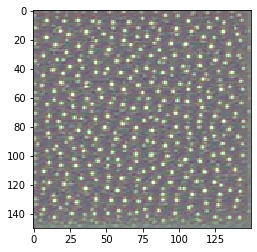

In [0]:
plt.imshow(generate_pattern('block3_conv1', 0))

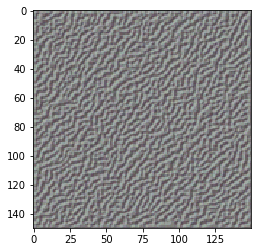

In [0]:
plt.imshow(generate_pattern('block1_conv1', 0))

In [0]:
# Generate Grid of filter response patterns for specified layer
def plot_layer_filter_responses(layer_name):
  size=64
  margin=5
  results = np.zeros((8*size + 7*margin, 8*size + 7*margin, 3))

  for i in range(8):
    for j in range(8):
      filter_img = generate_pattern(layer_name, i+(j*8), size=size)
      horizontal_start = i*size + i*margin
      horizontal_end = horizontal_start + size
      vertical_start = j*size + j*margin
      vertical_end = vertical_start + size
      results[horizontal_start: horizontal_end,
              vertical_start: vertical_end, :] = filter_img

  plt.figure(figsize=(15, 15))
  plt.title(layer_name)
  plt.imshow(results.astype(np.uint8))


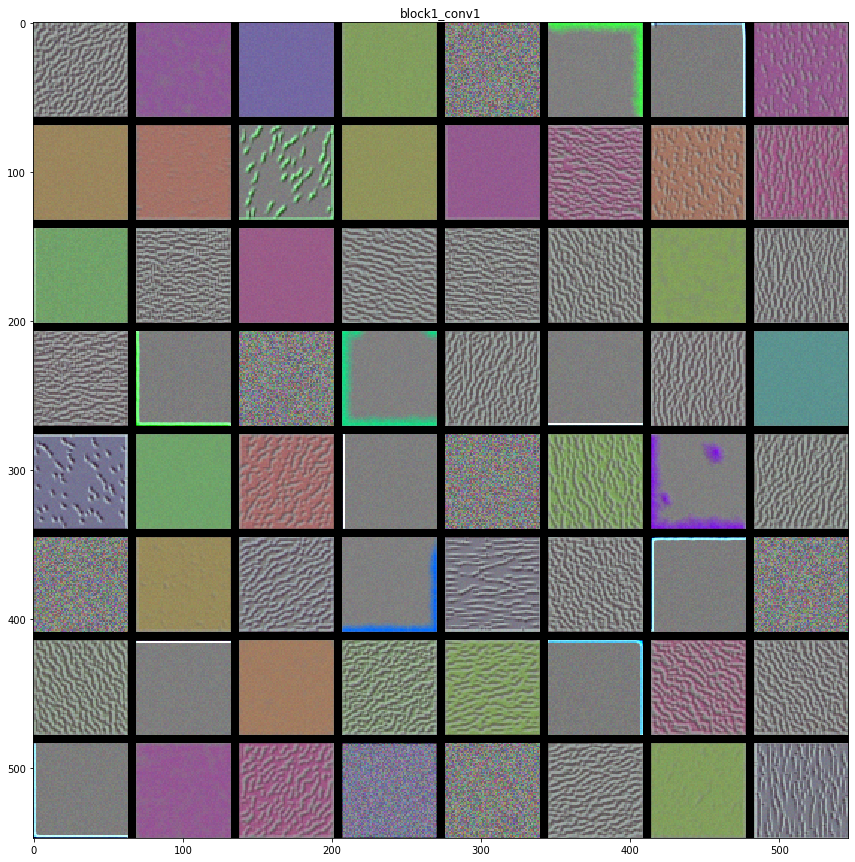

In [0]:
plot_layer_filter_responses('block1_conv1')

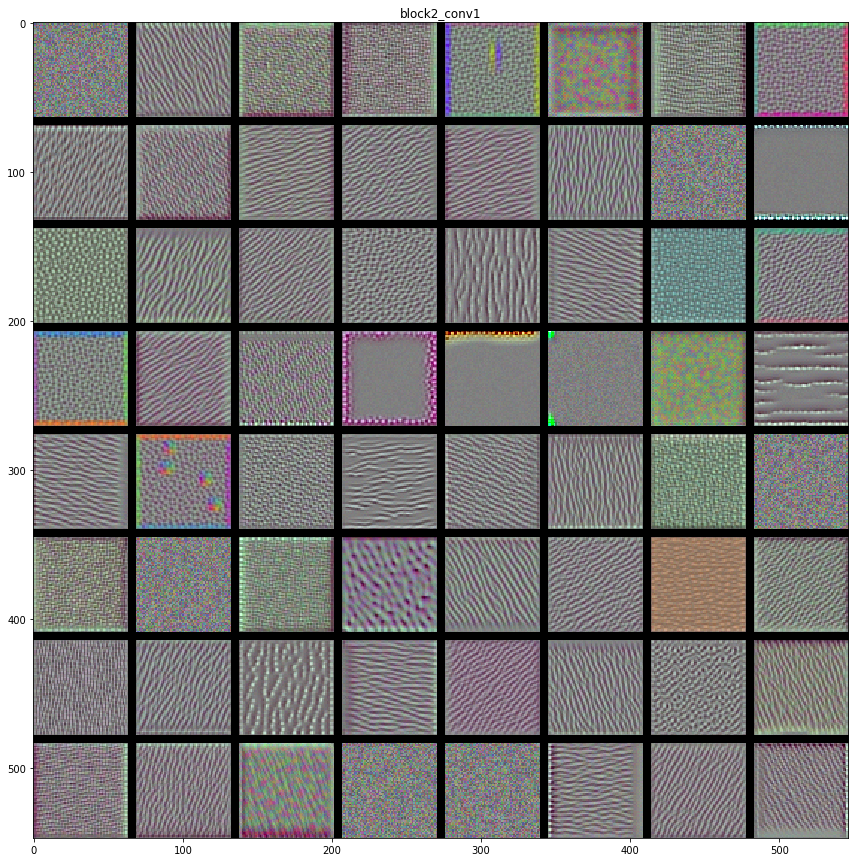

In [0]:
plot_layer_filter_responses('block2_conv1')

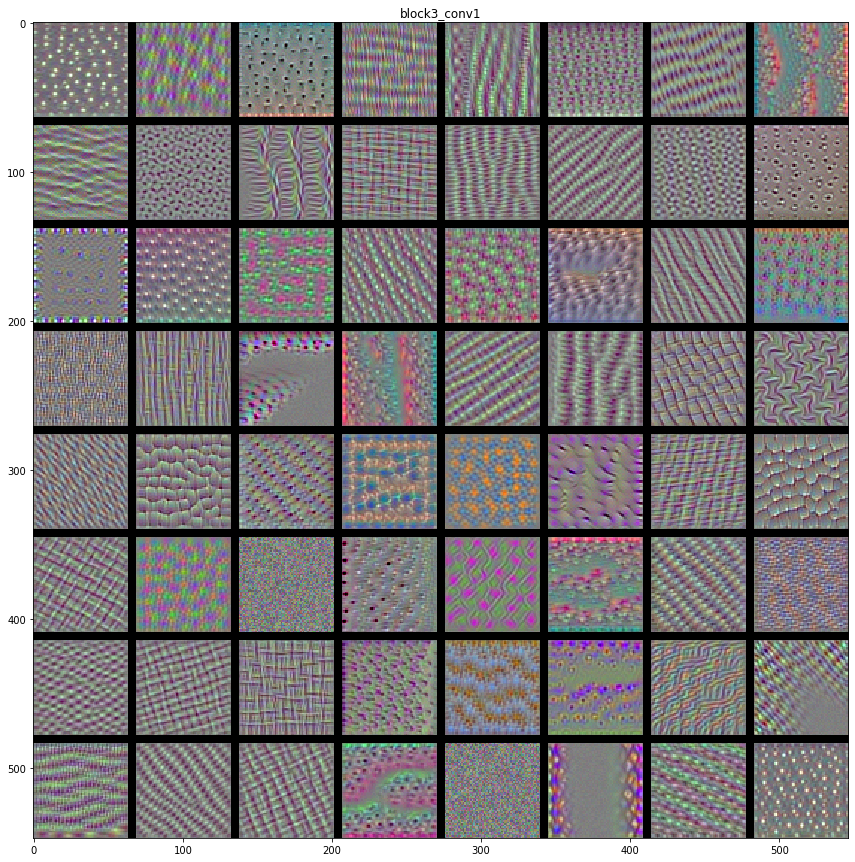

In [0]:
plot_layer_filter_responses('block3_conv1')

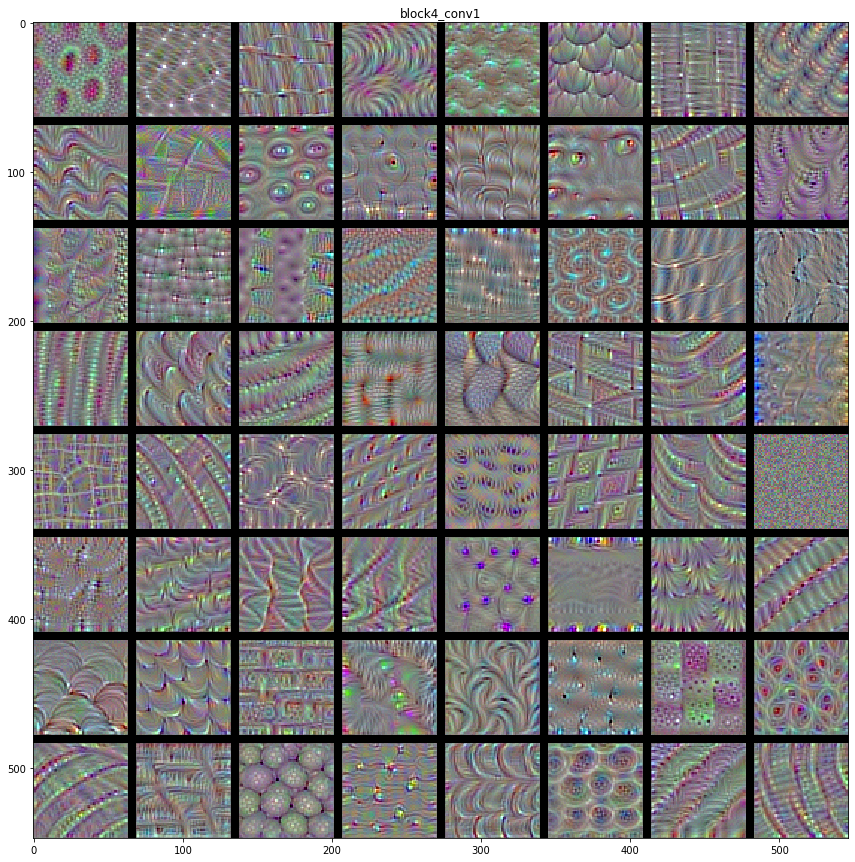

In [0]:
plot_layer_filter_responses('block4_conv1')

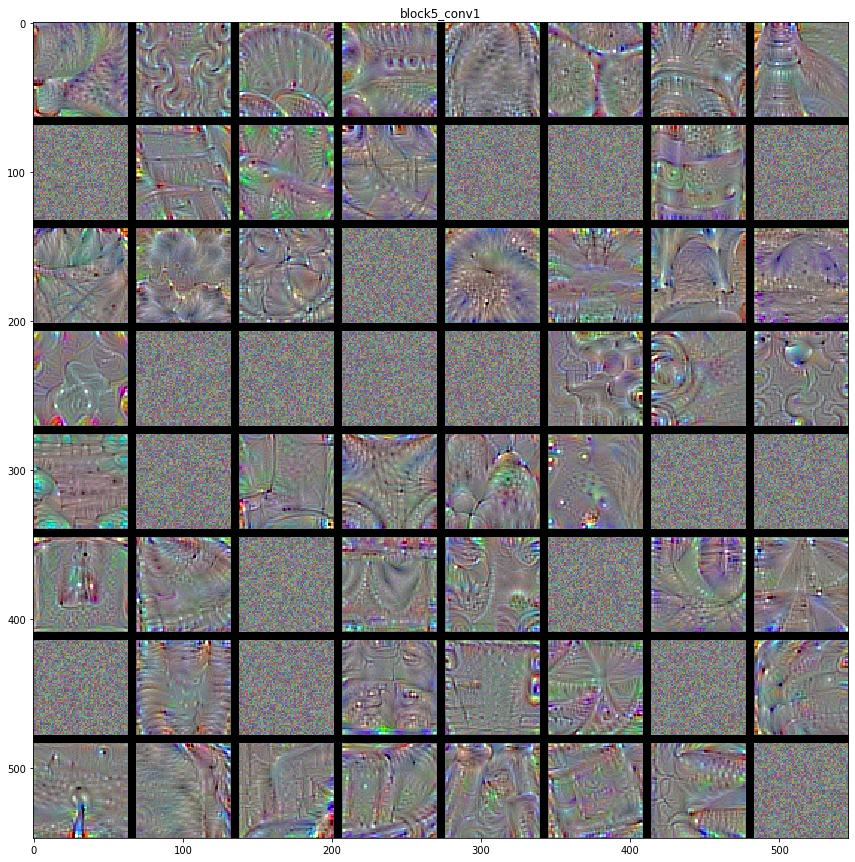

In [0]:
plot_layer_filter_responses('block5_conv1')

## Class Activation Maps
To visualize the class activation maps (CAM), we will produce a 2D grid of scores over an input image. The scores indicate how important that region is with regards to determining the class of interest. Once again we will be using the pretrained VGG16 CNN model.


In [0]:
model = VGG16(weights='imagenet')

# Preprocess input image
img_path = base_dir + '/creative_commons_elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [0]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.90942144), ('n01871265', 'tusker', 0.08618243), ('n02504013', 'Indian_elephant', 0.0043545677)]


Testing the prediction of the image, we find that the model believes it is most likely an African elephant with 91% probability.

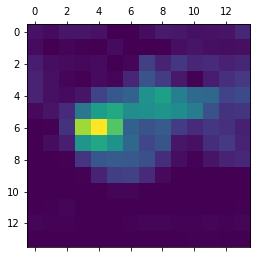

In [0]:
## Setup CAM
predIndex = np.argmax(preds[0]) #index for african elephant class

african_elephant_output = model.output[:, predIndex]
last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

# 512 output channels, Multiplies output feature map by channel importance for prediction
for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1) #Take channel-wise mean

# Post process heatmap values to be between 0 & 1
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

With the heatmap generated, we can overlay it with the original image to identify which areas of the picture contribute the most to the 'African elephant' class prediction.

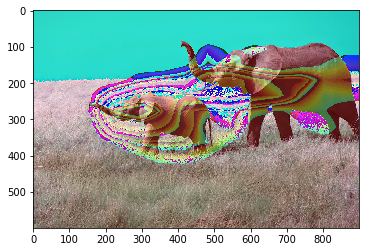

In [0]:
# Superimpose CAM with original image
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
plt.imshow(superimposed_img.astype(np.uint8))
plt.show()

The visualization of the overlayed heatmap indicates that the neural net thinks the elephants' ears and trunk are important features for African elephant classification.

